# Natural Language Processing, Topic Modeling, and Sentiment Analysis on E-Commerce Product Review Dataset

In this project, using the dataset from Amazon Customer Review (https://registry.opendata.aws/amazon-reviews/), unsupervised learning models are applied to automatically analyze the underlying structures of user reviews on grocery products, and to visualize the results by multiple natural language processing (NLP) models/tools.

* [Part I: Load Data](#Part-I:-Load-Data)
* [Part II: Tokenizing and Stemming](#Part-II:-Tokenizing-and-Stemming)
* [Part III: TF-IDF](#Part-III:-TF-IDF)
* [Part IV: K-Means clustering](#Part-IV:-K-Means-Clustering)
* [Part V: Topic Modeling - Latent Dirichlet Allocation](#Part-V:-Topic-Modeling-using-Latent-Dirichlet-Allocation)
* [Part VI: Sentiment Analysis - Naïve Bayes](#Part-VI:-Sentiment-Analysis---Naïve-Bayes)

In [22]:
import boto3
import botocore
import json
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Part I: Load Data

Load Amazon customer review data on grocery shopping "amazon_reviews_us_Grocery_v1_00.tsv.gz" using AWS S3

Data Size: 1 GB

In [ ]:
glue = boto3.client('glue')
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

session = boto3.session.Session()
region = session.region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

bucket = 'escience-workshop-donshen'
amazon_review_bucket = 'amazon-reviews-pds'

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [23]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket, CreateBucketConfiguration={'LocationConstraint': region})
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket {0} could not be created.'.format(bucket)
    return 'Created {0} bucket.'.format(bucket)

In [15]:
create_bucket(bucket)

ERROR:root:An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


'Bucket escience-workshop-donshen could not be created.'

In [18]:
try:
    s3_resource.Bucket(amazon_review_bucket).download_file('tsv/amazon_reviews_us_Grocery_v1_00.tsv.gz', 'amazon_reviews_us_Grocery_v1_00.tsv.gz')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [19]:
!gzip -d amazon_reviews_us_Grocery_v1_00.tsv.gz

In [24]:
import nltk
#import gensim
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhengyuanshen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhengyuanshen/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
# Load data into dataframe
df = pd.read_csv('amazon_reviews_us_Grocery_v1_00.tsv', sep='\t', error_bad_lines=False)

b'Skipping line 1925: expected 15 fields, saw 22\nSkipping line 1977: expected 15 fields, saw 22\nSkipping line 35265: expected 15 fields, saw 22\nSkipping line 53357: expected 15 fields, saw 22\n'
b'Skipping line 68361: expected 15 fields, saw 22\nSkipping line 70922: expected 15 fields, saw 22\nSkipping line 73503: expected 15 fields, saw 22\nSkipping line 85612: expected 15 fields, saw 22\nSkipping line 102322: expected 15 fields, saw 22\n'
b'Skipping line 158341: expected 15 fields, saw 22\nSkipping line 162872: expected 15 fields, saw 22\nSkipping line 195697: expected 15 fields, saw 22\n'
b'Skipping line 202916: expected 15 fields, saw 22\nSkipping line 203949: expected 15 fields, saw 22\nSkipping line 250853: expected 15 fields, saw 22\n'
b'Skipping line 265820: expected 15 fields, saw 22\nSkipping line 304569: expected 15 fields, saw 22\nSkipping line 313136: expected 15 fields, saw 22\nSkipping line 313160: expected 15 fields, saw 22\nSkipping line 316345: expected 15 fields, 

In [26]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix, 23-Ounce Bags (Pack of 6)",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years.",2015-08-31
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",Grocery,5,0.0,0.0,N,Y,Wonderful,"My favorite nut. Creamy, crunchy, salty, and slightly sweet - what more could you ask for?",2015-08-31
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Matcha (No Sugar Added - Unsweetened Pure Green Tea - No Coloring Added Like Others) 4oz,Grocery,5,0.0,0.0,N,N,Five Stars,This green tea tastes so good! My girlfriend loves it too.,2015-08-31
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,Grocery,5,0.0,0.0,N,Y,Five Stars,I love Melissa's brand but this is a great second when I can't get Melissa's brand.,2015-08-31
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-Count (Pack of 12)",Grocery,5,0.0,0.0,N,Y,Five Stars,good,2015-08-31


In [27]:
# Remove missing value
df.dropna(subset=['review_body'],inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2393291 entries, 0 to 2393378
Data columns (total 15 columns):
marketplace          object
customer_id          int64
review_id            object
product_id           object
product_parent       int64
product_title        object
product_category     object
star_rating          object
helpful_votes        float64
total_votes          float64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtypes: float64(2), int64(2), object(11)
memory usage: 292.1+ MB


In [29]:
# use the first 5000 data as our training data
data = df.loc[:5000, 'review_body'].tolist()

# Part II: Tokenizing and Stemming

## Load stopwords and stemmer function from nltk library

In [37]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'d")
stopwords.append("'m")
stopwords.append("n't")
stopwords.append("br")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords)

We use 184 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not

## Define functions to tokenize and stem the product reviews

In [38]:
from nltk.stem.snowball import SnowballStemmer
import re

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [39]:
tokenization_and_stemming(data[0])

['famili',
 'allerg',
 'wheat',
 'dairi',
 'egg',
 'nut',
 'sever',
 'thing',
 'love',
 'entir',
 'crave',
 'place',
 'line',
 'product',
 'allow',
 'us',
 'bake',
 'treat',
 'minim',
 'effort',
 'ingredi',
 'allergy-fre',
 'gluten-fre',
 'mix',
 'usual',
 'omit',
 'one',
 'two',
 'allergen',
 'great',
 'see',
 'mix',
 'creat',
 'without',
 'mani',
 'common',
 'allergen',
 'note',
 'still',
 'soy',
 'corn',
 'consum',
 'regular',
 'basi',
 'year']

# Part III: TF-IDF

## Use TF (term frequency) and IDF (inverse document frequency) to reflect word importance 

In [40]:
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                              min_df=0.01, stop_words='english',
                              use_idf=True, tokenizer=tokenization_and_stemming, 
                              ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

/Users/zhengyuanshen/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In total, there are 5000 reviews and 220 terms.


In [42]:
# check the parameters
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.99,
 'max_features': 1000,
 'min_df': 0.01,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

## Save the selected "words" by TF-IDF

In [43]:
# words
tf_selected_words = tfidf_model.get_feature_names()
# print out words
tf_selected_words

['abl',
 'absolut',
 'actual',
 'ad',
 'add',
 'alway',
 'amaz',
 'amazon',
 'anoth',
 'anyth',
 'arriv',
 'ask',
 'away',
 'awesom',
 'bad',
 'bag',
 'bake',
 'bar',
 'bean',
 'best',
 'better',
 'big',
 'bit',
 'bitter',
 'bottl',
 'bought',
 'box',
 'brand',
 'butter',
 'buy',
 'ca',
 'calori',
 'came',
 'candi',
 'cheaper',
 'chip',
 'chocol',
 'coconut',
 'coffe',
 'color',
 'come',
 'compani',
 'contain',
 'cook',
 'cooki',
 'cream',
 'crowdtap',
 'cup',
 'dark',
 'daughter',
 'day',
 'definit',
 'delici',
 'deliveri',
 'describ',
 'diet',
 'differ',
 'disappoint',
 'dri',
 'drink',
 'easi',
 'eat',
 'energi',
 'enjoy',
 'especi',
 'everi',
 'exact',
 'excel',
 'expect',
 'expens',
 'famili',
 'far',
 'fast',
 'favorit',
 'feel',
 'fine',
 'flavor',
 'food',
 'free',
 'fresh',
 'friend',
 'fruit',
 'gift',
 'glad',
 'gluten',
 'good',
 'got',
 'great',
 'green',
 'groceri',
 'happi',
 'hard',
 'healthi',
 'help',
 'high',
 'home',
 'hope',
 'hot',
 'howev',
 'husband',
 'ice',
 '

# Part IV: K-Means Clustering

In [72]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters = 6

# number of clusters
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

## K-Means Result Analysis

In [73]:
# create DataFrame films from all of the input files.
product = { 'review': df[:5000].review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

frame.head(10)

,review,cluster
0,"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years.",0
1,"My favorite nut. Creamy, crunchy, salty, and slightly sweet - what more could you ask for?",0
2,This green tea tastes so good! My girlfriend loves it too.,2
3,I love Melissa's brand but this is a great second when I can't get Melissa's brand.,0
4,good,5
5,The popcorn was stale.,0
6,"Love these bars, but have to watch out for the fat and sugar grams",2
7,Love the taste but the price was too high and it doesn't come in a 6 or 12 pack.,0
8,I'm a member of the crowdtap jif program and jif sent me a sample of its jif bars to try and review and my family and I loved them!great peanut butter taste and so easy to take with you whenever you need a great snack!,0
9,Used to be a decent product. Disgusting now and difficult on digestion. All 3 purchased from Costco over past couple months end in same result -- open the container and it smells like rancid oil. Something not right about how they are making/processing this powder now. Will not buy again.,0


In [75]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()
# The cluster sizes are not very evenly distributed (may have some problems)

Number of reviews included in each cluster:


,cluster
0,2911
4,560
1,515
2,403
5,402
3,209


In [76]:
# Find the coordinates for all the cluster centroids 
km.cluster_centers_

array([[0.00538762, 0.0055802 , 0.00565078, ..., 0.00778941, 0.00761053,
        0.01604547],
       [0.        , 0.        , 0.        , ..., 0.00134549, 0.00097248,
        0.00211536],
       [0.00103179, 0.00958027, 0.00074625, ..., 0.00093314, 0.00558681,
        0.00135906],
       [0.00271164, 0.01931942, 0.        , ..., 0.01059895, 0.00376528,
        0.01686156],
       [0.00439928, 0.00910675, 0.00580957, ..., 0.0033671 , 0.02738942,
        0.00346572],
       [0.        , 0.        , 0.        , ..., 0.00158144, 0.        ,
        0.        ]])

In [77]:
km.cluster_centers_.shape

(6, 220)

In [78]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
    print (", ".join(cluster_reviews[:10]))
    print ()

<Document clustering result by K-means>
Cluster 0 words:like,tast,flavor,product,best,tea,
Cluster 0 reviews (2911 reviews): 
As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years., My favorite nut.  Creamy, crunchy, salty, and slightly sweet - what more could you ask for?, I love Melissa's brand but this is a great second when I can't get Melissa's brand., The popcorn was stale., Love the taste but the price was too high and it doesn't come in a 6 or 12 pack., I'm a member of the crowdtap jif program and jif sent me a sample of its jif bars to try and review and my family and I 

# Part V: Topic Modeling using Latent Dirichlet Allocation

In [81]:
# Use LDA for clustering
# Divide the whole data into 6 topics
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=6)

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
# LDA requires integer values
tfidf_model_lda = CountVectorizer(max_df=0.99, max_features=500,
                                 min_df=0.01, stop_words='english',
                                 tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix_lda = tfidf_model_lda.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix_lda.shape[0]) + \
      " reviews and " + str(tfidf_matrix_lda.shape[1]) + " terms.")

/Users/zhengyuanshen/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In total, there are 5000 reviews and 220 terms.


In [83]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix_lda)
print(lda_output.shape)
print(lda_output)

(5000, 6)
[[0.01055905 0.08857536 0.34178775 0.16666283 0.38196602 0.01044899]
 [0.04204719 0.04166668 0.78998779 0.04225052 0.04180665 0.04224118]
 [0.02780808 0.02780262 0.0278429  0.58805433 0.02811658 0.3003755 ]
 ...
 [0.04215515 0.04169538 0.04176124 0.04213827 0.04224377 0.79000621]
 [0.00646817 0.00644449 0.0064364  0.48591674 0.29644088 0.19829332]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]


In [84]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(6, 220)
[[  0.26324649   0.24312141  15.77898499 ...  11.9171706   65.89865659
    0.16694647]
 [ 14.08062185  10.46516622   0.27696113 ...  45.08381829   5.66106277
    0.16743588]
 [ 16.54173063  34.13531708   4.44246106 ...  11.1358724    9.15736662
  101.16350514]
 [ 29.56467871  20.89744716  11.59864649 ...   2.16117175  63.53881119
    0.16759661]
 [  4.38222507   0.1675668   47.709199   ...   4.53379432   1.56156852
    0.16710682]
 [  0.16749725  16.09138134   0.19374734 ...   0.16817264   0.18253431
    0.16740908]]


In [85]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,topic
Doc0,0.01,0.09,0.34,0.17,0.38,0.01,4
Doc1,0.04,0.04,0.79,0.04,0.04,0.04,2
Doc2,0.03,0.03,0.03,0.59,0.03,0.30,3
Doc3,0.02,0.18,0.02,0.72,0.02,0.02,3
Doc4,0.08,0.08,0.08,0.08,0.08,0.58,5
Doc5,0.17,0.17,0.17,0.17,0.17,0.17,0
Doc6,0.04,0.04,0.59,0.04,0.24,0.04,2
Doc7,0.02,0.53,0.02,0.18,0.23,0.02,1
Doc8,0.01,0.01,0.96,0.01,0.01,0.01,2
Doc9,0.01,0.46,0.10,0.01,0.40,0.01,1


In [86]:
df_document_topic['topic'].value_counts().to_frame()

,topic
1,1156
3,939
4,860
0,845
5,624
2,576


In [87]:
# topic word matrix
print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model_lda.get_feature_names()
df_topic_words.index = topic_names

df_topic_words.head()

[[  0.26324649   0.24312141  15.77898499 ...  11.9171706   65.89865659
    0.16694647]
 [ 14.08062185  10.46516622   0.27696113 ...  45.08381829   5.66106277
    0.16743588]
 [ 16.54173063  34.13531708   4.44246106 ...  11.1358724    9.15736662
  101.16350514]
 [ 29.56467871  20.89744716  11.59864649 ...   2.16117175  63.53881119
    0.16759661]
 [  4.38222507   0.1675668   47.709199   ...   4.53379432   1.56156852
    0.16710682]
 [  0.16749725  16.09138134   0.19374734 ...   0.16817264   0.18253431
    0.16740908]]


,abl,absolut,actual,ad,add,alway,amaz,amazon,anoth,anyth,...,water,way,week,wish,wo,wonder,work,worth,year,yummi
Topic0,0.263246,0.243121,15.778985,49.848587,113.217219,10.407360,50.822612,12.135467,9.932833,33.992854,...,131.405693,27.482174,0.495188,15.623719,1.435061,80.897979,41.004554,11.917171,65.898657,0.166946
Topic1,14.080622,10.465166,0.276961,0.169164,0.168568,19.284657,17.308984,56.902976,6.657034,0.167420,...,0.167525,26.401126,29.764014,45.549088,0.167884,24.582578,108.119139,45.083818,5.661063,0.167436
Topic2,16.541731,34.135317,4.442461,9.868909,0.167289,21.816996,0.169558,2.399833,2.757080,0.168156,...,0.166915,9.679415,0.526381,0.170083,0.416937,0.569757,17.250429,11.135872,9.157367,101.163505
Topic3,29.564679,20.897447,11.598646,8.069910,0.253574,42.870633,21.890656,47.484084,26.516606,12.272529,...,14.071470,2.638487,29.254405,0.168647,12.815942,29.798215,42.575283,2.161172,63.538811,0.167597
Topic4,4.382225,0.167567,47.709199,34.876109,52.026148,0.167737,1.027569,21.819559,16.091619,27.231760,...,18.020932,81.069508,0.167871,11.905292,36.333104,0.984331,36.875580,4.533794,1.561569,0.167107


In [88]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model_lda, lda_model=lda, n_words=15)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,use,make,flavor,salt,sauc,bottl,hot,water,add,time,like,tasti,small,need,cook
Topic 1,great,product,price,buy,excel,love,time,qualiti,thank,order,work,fresh,organ,ship,packag
Topic 2,delici,bar,best,snack,oil,love,tri,eat,peanut,butter,yummi,great,protein,coconut,ask
Topic 3,love,coffe,tea,flavor,drink,order,tri,tast,favorit,cup,day,best,green,bean,ve
Topic 4,tast,like,great,flavor,better,tri,realli,sugar,good,chocol,milk,mix,buy,use,thing
Topic 5,good,flavor,candi,stuff,love,tast,kid,nice,melt,price,bag,perfect,hard,order,delici


# Part VI: Sentiment Analysis - Naïve Bayes

## Collect star rating and reviews

In [97]:
df_rating = df[['star_rating' , 'review_body' , 'review_headline' , 'verified_purchase']]
df_senti= df_rating[df_rating["star_rating"].notnull()]
df_rating.head()

,star_rating,review_body,review_headline,verified_purchase
0,5,"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years.",Using these for years - love them.,Y
1,5,"My favorite nut. Creamy, crunchy, salty, and slightly sweet - what more could you ask for?",Wonderful,Y
2,5,This green tea tastes so good! My girlfriend loves it too.,Five Stars,N
3,5,I love Melissa's brand but this is a great second when I can't get Melissa's brand.,Five Stars,Y
4,5,good,Five Stars,Y


## Classifying text as postive and negative

In [216]:
df_senti["senti"] = pd.to_numeric(df_senti["star_rating"])>=4
df_senti["senti"] = df_senti["senti"].replace([True , False] , ["positive" , "negative"])

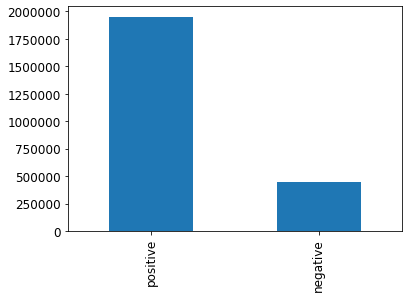

In [217]:
df_senti["senti"].value_counts().plot.bar()

## Review text clean-ups

In [111]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

In [116]:
re_clean = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = re_clean.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

df_senti["Summary_Clean"] = df_senti["review_body"].apply(cleanup)


## Train-Test Split

Pick 100,000 data points for training and testing

In [185]:
split = df_senti[["Summary_Clean" , "senti"]].iloc[:100000,:]
train = split.sample(frac=0.8, random_state=333)
test = split.drop(train.index)

In [186]:
def word_feats(words):
    features = {}
    for word in words:
        features [word] = True
    return features

## NLTK naive Bayes classifier for feature extraction

In [187]:
train["words"] = train["Summary_Clean"].str.lower().str.split()
test["words"] = test["Summary_Clean"].str.lower().str.split()

train.index = range(train.shape[0])
test.index = range(test.shape[0])

prediction =  {} ## For storing results of different classifiers

train_naive = []
test_naive = []

for i in range(train.shape[0]):
    train_naive = train_naive +[[word_feats(train["words"][i]), train["senti"][i]]]
for i in range(test.shape[0]):
    test_naive = test_naive +[[word_feats(test["words"][i]), test["senti"][i]]]



classifier = NaiveBayesClassifier.train(train_naive)
print("Accuracy : {}".format(nltk.classify.util.accuracy(classifier , test_naive)))
classifier.show_most_informative_features(10)

Accuracy : 0.6658
Most Informative Features
                inedible = True              neg : pos    =     43.5 : 1.0
                    yuck = True              neg : pos    =     41.2 : 1.0
              misleading = True              neg : pos    =     40.0 : 1.0
            unappetizing = True              neg : pos    =     39.6 : 1.0
                 salvage = True              neg : pos    =     33.3 : 1.0
             disapointed = True              neg : pos    =     30.1 : 1.0
                unusable = True              neg : pos    =     30.1 : 1.0
                explains = True              neg : pos    =     30.1 : 1.0
                  refund = True              neg : pos    =     29.9 : 1.0
                    glob = True              neg : pos    =     27.6 : 1.0


## predicting result of nltk classifier

In [188]:
y =[]
only_words= [test_naive[i][0] for i in range(test.shape[0])]
for i in range(test.shape[0]):
    y = y + [classifier.classify(only_words[i] )]
prediction["Naive"]= np.asarray(y)

y1 = []
for i in range(check.shape[0]):
    y1 = y1 + [classifier.classify(check_naive[i] )]

check["Naive"] = y1

In [189]:
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
stopwords.remove("not")

count_vect = CountVectorizer(min_df=2 ,stop_words=stopwords , ngram_range=(1,2))
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(train["Summary_Clean"])        
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


X_new_counts = count_vect.transform(test["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)


/Users/zhengyuanshen/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Bernoulli naive bayes

In [191]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB().fit(X_train_tfidf,train["senti"])
prediction['Bernoulli'] = bnb.predict_proba(X_test_tfidf)[:,1]
print("Bernoulli Accuracy : {}".format(bnb.score(X_test_tfidf , test["senti"])))


Bernoulli Accuracy : 0.84655


## Multinomial naive bayes

In [192]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train_tfidf , train["senti"])
prediction['Multinomial'] = mnb.predict_proba(X_test_tfidf)[:,1]
print("Multinomial Accuracy : {}".format(mnb.score(X_test_tfidf , test["senti"])))

Multinomial Accuracy : 0.84965


## Logistic Regression

In [194]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(solver='lbfgs' , C=1000)
logistic = lr.fit(X_train_tfidf, train["senti"])
prediction['LogisticRegression'] = lr.predict_proba(X_test_tfidf)[:,1]
print("Logistic Regression Accuracy : {}".format(lr.score(X_test_tfidf , test["senti"])))

Logistic Regression Accuracy : 0.9091


/Users/zhengyuanshen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Display the relative impacts on specific words on the overall sentiment

In [195]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(data = list(zip(words, logistic.coef_[0])), columns = ['feature', 'coefficient'])
feature_coefs.sort_values(by="coefficient")

,feature,coefficient
32992,disappointed,-34.074438
138444,yuck,-31.125953
120041,tasteless,-30.270989
81416,not worth,-28.676027
80617,not happy,-28.563140
...,...,...
38763,even better,30.941181
136404,won disappointed,31.953398
1143,addicted,39.454095
80189,not bitter,41.520666


## Model evaluation - ROC & AUC

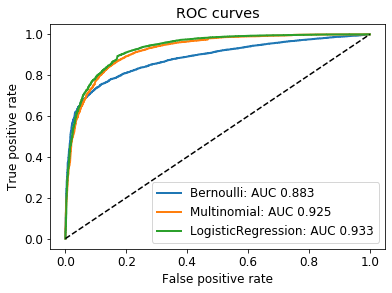

In [221]:
from sklearn.metrics import roc_curve
from sklearn import metrics

def formatt(rate):
    if rate == 'neg':
        return 0
    if rate == 0:
        return 0
    return 1
vfunc = np.vectorize(formatt)


for model, predicted in prediction.items():
    if model not in 'Naive':
        fpr, tpr, thresh = roc_curve(test["senti"].map(vfunc), predicted)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s: AUC %0.3f'% (model,auc), linewidth = 2)
     
plt.title('ROC curves')
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

In [197]:
test.senti = test.senti.replace(["pos" , "neg"] , [True , False] )

In [198]:
for key in ['Multinomial', 'Bernoulli', 'LogisticRegression']:
    print(" {}:".format(key))
    print(metrics.classification_report(test["senti"], prediction.get(key)>.5, target_names = ["positive", "negative"]))
    print("\n")

 Multinomial:
              precision    recall  f1-score   support

    positive       0.98      0.14      0.24      3484
    negative       0.85      1.00      0.92     16516

    accuracy                           0.85     20000
   macro avg       0.91      0.57      0.58     20000
weighted avg       0.87      0.85      0.80     20000



 Bernoulli:
              precision    recall  f1-score   support

    positive       0.59      0.39      0.47      3484
    negative       0.88      0.94      0.91     16516

    accuracy                           0.85     20000
   macro avg       0.74      0.67      0.69     20000
weighted avg       0.83      0.85      0.83     20000



 LogisticRegression:
              precision    recall  f1-score   support

    positive       0.77      0.68      0.72      3484
    negative       0.93      0.96      0.95     16516

    accuracy                           0.91     20000
   macro avg       0.85      0.82      0.83     20000
weighted avg       0.91

## Test the performance of the best model (Logistic Regression) by inputing some customized reviews

In [225]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Estimated as %s.\n\t\tnegative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(lr, "Absolutely wonderful! Loved this product and will buy again")
test_sample(lr, "Tastes strange...")    
test_sample(lr, "Nothing wrong")
test_sample(lr, "Horrible product! Didn't expect.")
test_sample(lr, "My kids like it sooooo much")

Estimated as POS.
		negative prob 0.000000, positive prob 1.000000
Estimated as NEG.
		negative prob 0.995554, positive prob 0.004446
Estimated as NEG.
		negative prob 0.883846, positive prob 0.116154
Estimated as POS.
		negative prob 0.128775, positive prob 0.871225
Estimated as POS.
		negative prob 0.000098, positive prob 0.999902


## Visualize words that possibly result in positive/negative sentiments

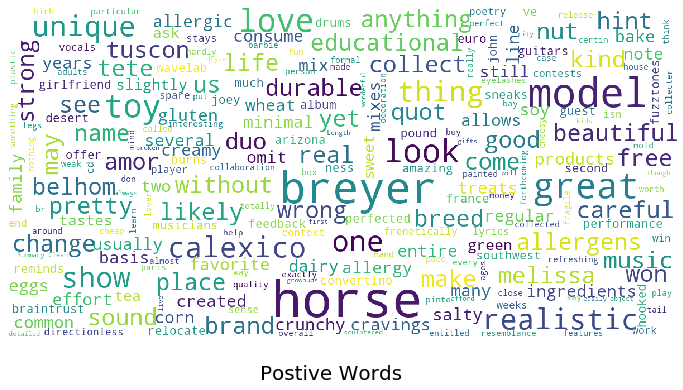

In [214]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
        
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(senti["Summary_Clean"][df_senti.senti == "pos"] , title="Postive Words")

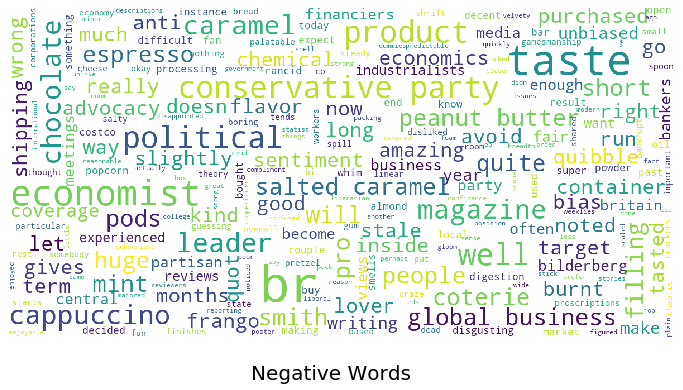

In [215]:
show_wordcloud(senti["Summary_Clean"][df_senti.senti == "neg"] , title="Negative Words")